<a href="https://colab.research.google.com/github/mansine/Electricity-Consumption/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping



# DATA PROCESSING

In [2]:
#reading the dataset
df=pd.read_csv("/content/File1.txt",header = None,delimiter = ' ')
#adding columns in the data
df.columns = ['MeterID','DateTime','ElectricityConsumption']
#checking the range of DateTime column
df['DateTime'].min() , df['DateTime'].max()
#Keep the DataFrame with valid entries in the same variable.
df.dropna(inplace=True)
#seperating days and time from 5 digits DateTime columns
#Converting DateTime datatype from integer to string
df['DateTime'] = df['DateTime'].astype('str')
new = df['DateTime'].str.split("", n =0, expand = True)
#First 2digits are days in 2year readings
df['date'] = new[1] + new[2] + new[3] 
#Last 2digits showing time code
df['time_in_minutes'] = new[4] + new[5]
#No more need of duplicated data
df.drop('DateTime', axis=1, inplace=True)
#convert string to integer
df['date'] = df['date'].astype(int)
df['time_in_minutes'] = df['time_in_minutes'].astype(int)
# convert the mins to real time by multiplying it by 30 mins
df['time_in_minutes']=df['time_in_minutes']*30
df.isnull().sum()
#sorting the value in ascending order by MererID,date and time_in_minutes
df.sort_values(['MeterID','date','time_in_minutes'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [3]:
#covert minutes data into hours
df['hours']=pd.to_datetime(df.time_in_minutes,unit ='m').dt.strftime('%H:%M')
#coverting days of year into actual date
year=2009
df['Date']=pd.to_datetime(df.date,unit='D', origin=str(year))




```
# This is formatted as code
```

# New Data

In [12]:
# Drop unwanted attributes
df=df.drop(['time_in_minutes', 'MeterID','date'], axis = 1)

#kilowatt consumption per day is aggregated
df=df.groupby(['Date']).agg('mean')


In [13]:
df.head()

,ElectricityConsumption
Date,
2009-07-15,0.6336
2009-07-16,0.6121
2009-07-17,0.6066
2009-07-18,0.6118
2009-07-19,0.5785


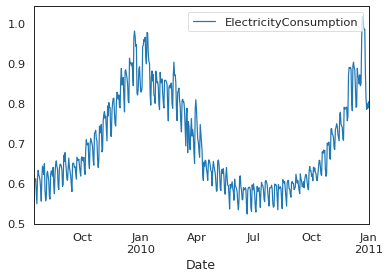

In [14]:
df.plot()
plt.show()

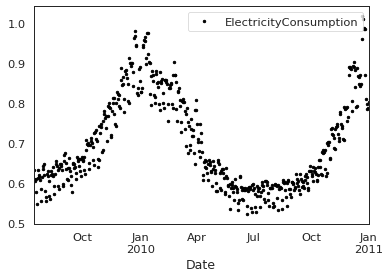

In [15]:
df.plot(style='k.')
plt.show()

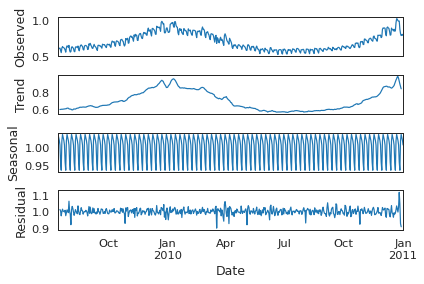

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

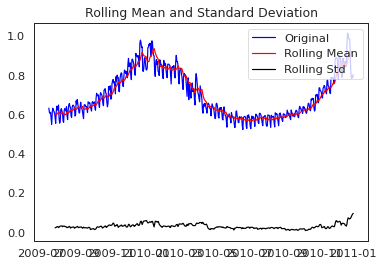

Results of dickey fuller test
Test Statistics                -0.7448
p-value                         0.8348
No. of lags used               14.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['ElectricityConsumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

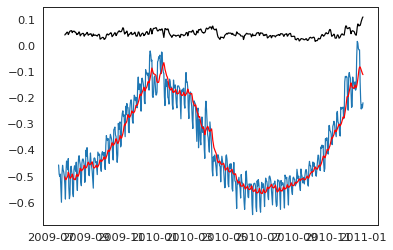

In [18]:
import numpy as np
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

In [19]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

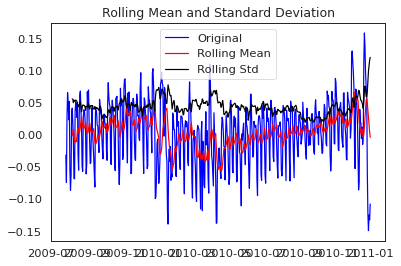

Results of dickey fuller test
Test Statistics                -3.7933
p-value                         0.0030
No. of lags used               14.0000
Number of observations used   510.0000
critical value (1%)            -3.4432
critical value (5%)            -2.8672
critical value (10%)           -2.5698
dtype: float64


In [20]:
test_stationarity(df_log_moving_avg_diff)


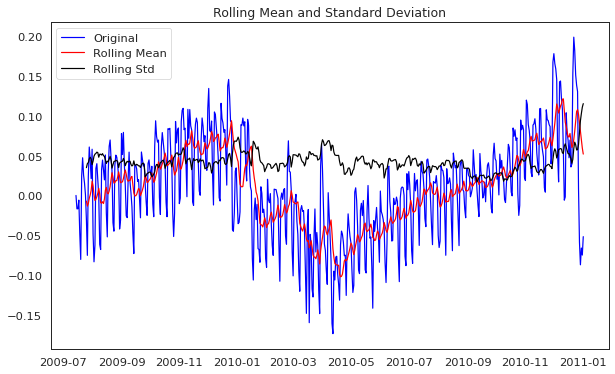

Results of dickey fuller test
Test Statistics                -1.7558
p-value                         0.4026
No. of lags used               14.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [21]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

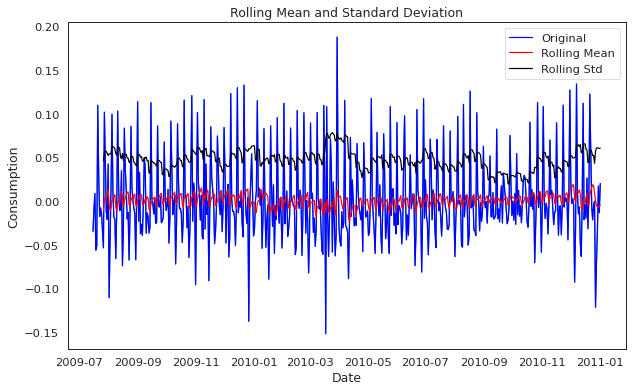

Results of dickey fuller test
Test Statistics                -7.1648
p-value                         0.0000
No. of lags used               13.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [22]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

In [23]:
dataset = df_log_diff.ElectricityConsumption.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [25]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
6/6 [==============================] - 2s 108ms/step - loss: 0.1131 - val_loss: 0.0241
Epoch 2/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0212 - val_loss: 0.0361
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0322 - val_loss: 0.0272
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0177 - val_loss: 0.0211
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0183 - val_loss: 0.0183
Epoch 7/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0154 - val_loss: 0.0182
Epoch 8/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 9/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0141 - val_loss: 0.0166
Epoch 10/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0162
Epoch 11/20
6/6 [===========

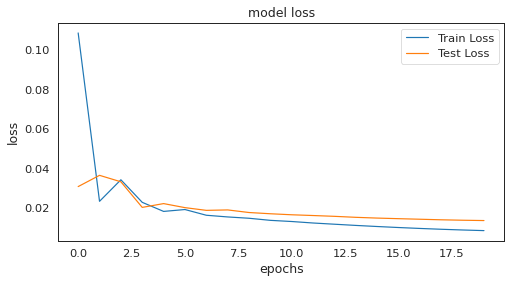

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Train Score: 0.03 RMSE
Test Score: 0.04 RMSE


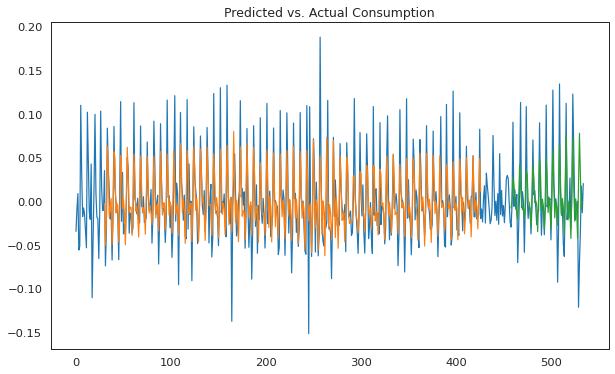

In [26]:
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[look_back:len(trainpred)+look_back, :] = trainpred

testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(look_back*2)+1:len(dataset)-1, :] = testpred

inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.title("Predicted vs. Actual Consumption")
plt.show()


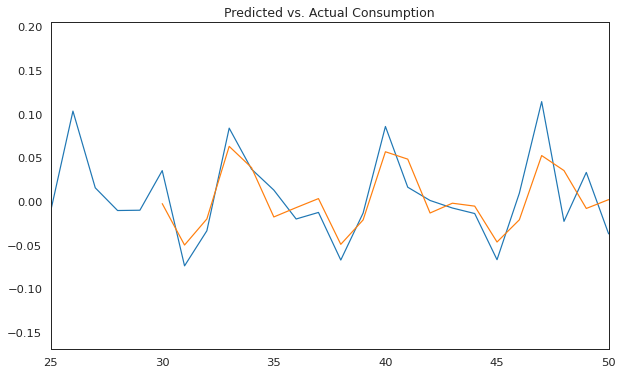

In [27]:
inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.xlim([25, 50])
plt.title("Predicted vs. Actual Consumption")
plt.show()

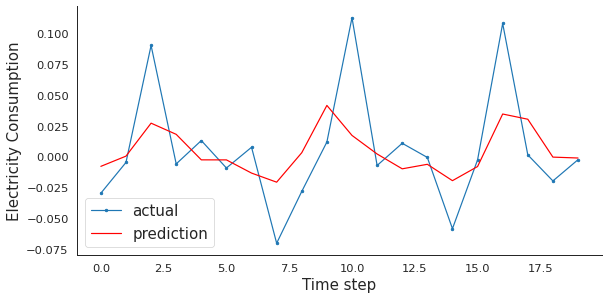

In [28]:
#Compare Actual vs. Prediction
aa=[x for x in range(20)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:20], marker='.', label="actual")
plt.plot(aa, predictions[:,0][:20], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Electricity Consumption', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();